In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import rasterio
import numpy as np
import torch.nn as nn
import torch.optim as optim
from skimage.transform import resize
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import geometry_mask
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.set_per_process_memory_fraction(0.8, 0)

tif_path = "G:/16_ECMWF/7_climate_10_520_400/1_tem/2017/tem_2017_01_01.tif"
with rasterio.open(tif_path) as src:
        image_data = src.read(1)  # 读取第一个波段
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
        height, width = src.height, src.width
        profile = src.profile  # 获取文件元数据以便后续导出
    
shp_path = "C:/Users/Administrator/Desktop/边界/九大农业区/Agr_qu.shp"
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(crs)
geometries = [mapping(geometry) for geometry in shapefile.geometry]
mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(height, width))

Using device: cuda


In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, tem_dirs, tem_min_dirs, tem_max_dirs, pr_dirs, wind_dirs, ps_dirs, solar_dirs, ther_dirs, rh_dirs, eva_dirs, transform=None):
        self.tem_files = self._get_all_files(tem_dirs)
        self.tem_min_files = self._get_all_files(tem_min_dirs)
        self.tem_max_files = self._get_all_files(tem_max_dirs)
        self.pr_files = self._get_all_files(pr_dirs)
        self.wind_files = self._get_all_files(wind_dirs)
        self.ps_files = self._get_all_files(ps_dirs)
        self.solar_files = self._get_all_files(solar_dirs)
        self.ther_files = self._get_all_files(ther_dirs)
        self.rh_files = self._get_all_files(rh_dirs)
        self.eva_files = self._get_all_files(eva_dirs)
        
        self.transform = transform

    def _get_all_files(self, dirs):
        all_files = []
        for directory in dirs:
            for filename in sorted(os.listdir(directory)):  # 排序保证匹配
                file_path = os.path.join(directory, filename)
                if os.path.isfile(file_path):  # 确保是文件
                    all_files.append(file_path)
        return all_files

    def __len__(self):
        return len(self.tem_files)

    def __getitem__(self, idx):
        tem_path = self.tem_files[idx]
        tem_min_path = self.tem_min_files[idx]
        tem_max_path = self.tem_max_files[idx]
        pr_path = self.pr_files[idx]
        wind_path = self.wind_files[idx]
        ps_path = self.ps_files[idx]
        solar_path = self.solar_files[idx]
        ther_path = self.ther_files[idx]
        rh_path = self.rh_files[idx]
        eva_path = self.eva_files[idx]
        
        with rasterio.open(tem_path) as tem_dataset:
            tem_image = tem_dataset.read(1)  
        with rasterio.open(tem_min_path) as tem_min_dataset:
            tem_min_image = tem_min_dataset.read(1)  
        with rasterio.open(tem_max_path) as tem_max_dataset:
            tem_max_image = tem_max_dataset.read(1)  
        with rasterio.open(pr_path) as pr_dataset:
            pr_image = pr_dataset.read(1)
            pr_image = pr_image*1000
        with rasterio.open(wind_path) as wind_dataset:
            wind_image = wind_dataset.read(1)  
        with rasterio.open(ps_path) as ps_dataset:
            ps_image = ps_dataset.read(1)  
            ps_image = ps_image/1000
        with rasterio.open(solar_path) as solar_dataset:
            solar_image = solar_dataset.read(1) 
            solar_image = solar_image/86400
        with rasterio.open(ther_path) as ther_dataset:
            ther_image = ther_dataset.read(1) 
            ther_image = ther_image/86400
        with rasterio.open(rh_path) as rh_dataset:
            rh_image = rh_dataset.read(1) 
        with rasterio.open(eva_path) as eva_dataset:
            eva_image = eva_dataset.read(1) 
            eva_image = eva_image

        # 如果有 transform，应用转换
        if self.transform:
            tem_image = self.transform(tem_image)
            tem_min_image = self.transform(tem_min_image)
            tem_max_image = self.transform(tem_max_image)
            pr_image = self.transform(pr_image)
            wind_image = self.transform(wind_image)
            ps_image = self.transform(ps_image)
            solar_image = self.transform(solar_image)
            ther_image = self.transform(ther_image)
            rh_image = self.transform(rh_image)
            eva_image = self.transform(eva_image)

        else:
        # 如果没有 transform，转换为 PyTorch 张量
            tem_image = torch.from_numpy(tem_image).float()  # (1, H, W)
            tem_min_image = torch.from_numpy(tem_min_image).float()  # (1, H, W)
            tem_max_image = torch.from_numpy(tem_max_image).float()  # (1, H, W)
            pr_image = torch.from_numpy(pr_image).float()  # (1, H, W)
            wind_image = torch.from_numpy(wind_image).float()  # (1, H, W)
            ps_image = torch.from_numpy(ps_image).float()  # (1, H, W)
            solar_image = torch.from_numpy(solar_image).float()  # (1, H, W)
            ther_image = torch.from_numpy(ther_image).float()  # (1, H, W)
            rh_image = torch.from_numpy(rh_image).float()  # (1, H, W)
            eva_image = torch.from_numpy(eva_image).float()  # (1, H, W)

        lr_image =  torch.cat([tem_image, tem_min_image,tem_max_image,pr_image,wind_image,ps_image,solar_image,ther_image,rh_image], dim=0)
            
        return lr_image, eva_image
# 定义数据增强和预处理操作
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # 将 NumPy 数组转换为 PyTorch 张量
])

def load_tiff_with_rasterio(file_path):
    with rasterio.open(file_path) as src:
        img = src.read(1)  # 读取第一个波段
        img = img
    return img

In [4]:
year = list(range(2000,2014))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_train = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=0)


year = list(range(2014,2019))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_val = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=True, num_workers=0)


year = list(range(2019,2024))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_test = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=0)

In [6]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader):
        inputs  = inputs.float().to(device)
        targets = targets.float().to(device)

        inputs[torch.isnan(inputs)] = 0
        targets[torch.isnan(targets)] = 0

        assert not torch.isnan(inputs).any(), "Input contains NaN values"
        assert not torch.isnan(targets).any(), "Target contains NaN values"
        
        optimizer.zero_grad()
        outputs_up = model(inputs)

        loss = criterion(outputs_up, targets).to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.float().to(device)
            targets =  targets.float().to(device)
            inputs[torch.isnan(inputs)] = 0
            targets[torch.isnan(targets)] = 0

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [7]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, num_features, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
            nn.Conv2d(num_features, num_features // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features // reduction, num_features, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y)
        return x * y

class RCAB(nn.Module):
    def __init__(self, num_features, reduction):
        super(RCAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(num_features, num_features, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, 3, padding=1),
            ChannelAttention(num_features, reduction)
        )

    def forward(self, x):
        return x + self.body(x)

class ResidualGroup(nn.Module):
    def __init__(self, num_features, num_blocks, reduction):
        super(ResidualGroup, self).__init__()
        self.body = nn.Sequential(
            *[RCAB(num_features, reduction) for _ in range(num_blocks)],
            nn.Conv2d(num_features, num_features, 3, padding=1)
        )

    def forward(self, x):
        return x + self.body(x)

class RCAN(nn.Module):
    def __init__(self, num_features=64, num_groups=10, num_blocks=20, reduction=16, scale=10, in_channels=9, out_channels=1):
        super(RCAN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, num_features, 3, padding=1)
        
        self.body = nn.Sequential(
            *[ResidualGroup(num_features, num_blocks, reduction) for _ in range(num_groups)],
            nn.Conv2d(num_features, num_features, 3, padding=1)
        )
        
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, num_features * (scale ** 2), 3, padding=1),
            nn.PixelShuffle(scale)
        )
        
        self.conv2 = nn.Conv2d(num_features, out_channels, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        res = self.body(x)
        res += x
        x = self.upsample(res)
        x = self.conv2(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = RCAN(num_features=64, num_groups=10, num_blocks=20, reduction=16, scale=10, in_channels=9, out_channels=1).to(device)

learning_rate = 0.0001
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

num_epochs = 100
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Model is training on: {next(model.parameters()).device}')
    train_loss = train_model(model, dataloader_train, criterion, optimizer, device)
    val_loss = validate_model(model, dataloader_val, criterion, device)
    print(f'Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/RCAN_pet.pth')
        print('Model saved!')


cuda
Epoch 1/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:29<00:00,  2.55it/s]


Train Loss: 34.6942 | Validation Loss: 3.4765
Model saved!
Epoch 2/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:23<00:00,  2.73it/s]


Train Loss: 2.6204 | Validation Loss: 2.1130
Model saved!
Epoch 3/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:23<00:00,  2.74it/s]


Train Loss: 1.7467 | Validation Loss: 1.5052
Model saved!
Epoch 4/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 1.3285 | Validation Loss: 1.1981
Model saved!
Epoch 5/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 1.0757 | Validation Loss: 0.9715
Model saved!
Epoch 6/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.9102 | Validation Loss: 0.8422
Model saved!
Epoch 7/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.7960 | Validation Loss: 0.8407
Model saved!
Epoch 8/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.6797 | Validation Loss: 0.6635
Model saved!
Epoch 9/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.5903 | Validation Loss: 0.5336
Model saved!
Epoch 10/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.5203 | Validation Loss: 0.4820
Model saved!
Epoch 11/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.4714 | Validation Loss: 0.4387
Model saved!
Epoch 12/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.4347 | Validation Loss: 0.4012
Model saved!
Epoch 13/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.4371 | Validation Loss: 0.3772
Model saved!
Epoch 14/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.3821 | Validation Loss: 0.3753
Model saved!
Epoch 15/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.3612 | Validation Loss: 0.3843
Epoch 16/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.3442 | Validation Loss: 0.3344
Model saved!
Epoch 17/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.3292 | Validation Loss: 0.3164
Model saved!
Epoch 18/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.3185 | Validation Loss: 0.3007
Model saved!
Epoch 19/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.3012 | Validation Loss: 0.3985
Epoch 20/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2952 | Validation Loss: 0.3091
Epoch 21/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2765 | Validation Loss: 0.3121
Epoch 22/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.9559 | Validation Loss: 0.5607
Epoch 23/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.4026 | Validation Loss: 0.3612
Epoch 24/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.3370 | Validation Loss: 0.3175
Epoch 25/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.3092 | Validation Loss: 0.2935
Model saved!
Epoch 26/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2931 | Validation Loss: 0.2796
Model saved!
Epoch 27/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2810 | Validation Loss: 0.2757
Model saved!
Epoch 28/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2696 | Validation Loss: 0.2800
Epoch 29/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2616 | Validation Loss: 0.2585
Model saved!
Epoch 30/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2529 | Validation Loss: 0.2518
Model saved!
Epoch 31/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2468 | Validation Loss: 0.2559
Epoch 32/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2386 | Validation Loss: 0.2467
Model saved!
Epoch 33/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2335 | Validation Loss: 0.2336
Model saved!
Epoch 34/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2262 | Validation Loss: 0.2618
Epoch 35/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2214 | Validation Loss: 0.2219
Model saved!
Epoch 36/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.2166 | Validation Loss: 0.2571
Epoch 37/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2088 | Validation Loss: 0.2095
Model saved!
Epoch 38/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2043 | Validation Loss: 0.2100
Epoch 39/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.2025 | Validation Loss: 0.2044
Model saved!
Epoch 40/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1979 | Validation Loss: 0.2014
Model saved!
Epoch 41/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1937 | Validation Loss: 0.2178
Epoch 42/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1907 | Validation Loss: 0.1917
Model saved!
Epoch 43/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1885 | Validation Loss: 0.1866
Model saved!
Epoch 44/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1842 | Validation Loss: 0.1959
Epoch 45/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1834 | Validation Loss: 0.1921
Epoch 46/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.95it/s]


Train Loss: 0.1774 | Validation Loss: 0.1744
Model saved!
Epoch 47/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1790 | Validation Loss: 0.1954
Epoch 48/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1749 | Validation Loss: 0.1808
Epoch 49/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1736 | Validation Loss: 0.1761
Epoch 50/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1710 | Validation Loss: 0.1714
Model saved!
Epoch 51/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1699 | Validation Loss: 0.1720
Epoch 52/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1695 | Validation Loss: 0.1736
Epoch 53/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1669 | Validation Loss: 0.1723
Epoch 54/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1656 | Validation Loss: 0.1661
Model saved!
Epoch 55/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1653 | Validation Loss: 0.1668
Epoch 56/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1646 | Validation Loss: 0.1707
Epoch 57/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1622 | Validation Loss: 0.1640
Model saved!
Epoch 58/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1614 | Validation Loss: 0.1668
Epoch 59/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:16<00:00,  2.97it/s]


Train Loss: 0.1615 | Validation Loss: 0.1649
Epoch 60/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1593 | Validation Loss: 0.1643
Epoch 61/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1590 | Validation Loss: 0.1676
Epoch 62/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1574 | Validation Loss: 0.1607
Model saved!
Epoch 63/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1568 | Validation Loss: 0.1769
Epoch 64/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1567 | Validation Loss: 0.1606
Model saved!
Epoch 65/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1559 | Validation Loss: 0.1680
Epoch 66/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1550 | Validation Loss: 0.1625
Epoch 67/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1537 | Validation Loss: 0.1707
Epoch 68/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1541 | Validation Loss: 0.1587
Model saved!
Epoch 69/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1525 | Validation Loss: 0.1611
Epoch 70/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1524 | Validation Loss: 0.1565
Model saved!
Epoch 71/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1510 | Validation Loss: 0.1575
Epoch 72/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1502 | Validation Loss: 0.1609
Epoch 73/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1508 | Validation Loss: 0.1566
Epoch 74/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1501 | Validation Loss: 0.1632
Epoch 75/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1496 | Validation Loss: 0.1539
Model saved!
Epoch 76/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1490 | Validation Loss: 0.1736
Epoch 77/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1490 | Validation Loss: 0.1580
Epoch 78/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1473 | Validation Loss: 0.1552
Epoch 79/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1492 | Validation Loss: 0.1649
Epoch 80/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1469 | Validation Loss: 0.1550
Epoch 81/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1473 | Validation Loss: 0.1553
Epoch 82/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1463 | Validation Loss: 0.1606
Epoch 83/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1471 | Validation Loss: 0.1739
Epoch 84/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1455 | Validation Loss: 0.1534
Model saved!
Epoch 85/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1461 | Validation Loss: 0.1573
Epoch 86/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.97it/s]


Train Loss: 0.1448 | Validation Loss: 0.1565
Epoch 87/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:17<00:00,  2.96it/s]


Train Loss: 0.1446 | Validation Loss: 0.1568
Epoch 88/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.93it/s]


Train Loss: 0.1438 | Validation Loss: 0.1508
Model saved!
Epoch 89/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.92it/s]


Train Loss: 0.1449 | Validation Loss: 0.1496
Model saved!
Epoch 90/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:23<00:00,  2.73it/s]


Train Loss: 0.1455 | Validation Loss: 0.1582
Epoch 91/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:22<00:00,  2.76it/s]


Train Loss: 0.1419 | Validation Loss: 0.1629
Epoch 92/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.93it/s]


Train Loss: 0.1429 | Validation Loss: 0.1505
Epoch 93/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.93it/s]


Train Loss: 0.1426 | Validation Loss: 0.1508
Epoch 94/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.91it/s]


Train Loss: 0.1415 | Validation Loss: 0.1540
Epoch 95/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.90it/s]


Train Loss: 0.1421 | Validation Loss: 0.1525
Epoch 96/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.91it/s]


Train Loss: 0.1424 | Validation Loss: 0.1493
Model saved!
Epoch 97/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.91it/s]


Train Loss: 0.1414 | Validation Loss: 0.1506
Epoch 98/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.91it/s]


Train Loss: 0.1415 | Validation Loss: 0.1478
Model saved!
Epoch 99/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.91it/s]


Train Loss: 0.1406 | Validation Loss: 0.1497
Epoch 100/100
Model is training on: cuda:0


100%|██████████| 229/229 [01:18<00:00,  2.90it/s]

Train Loss: 0.1403 | Validation Loss: 0.1577


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19528\1298798858.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_

torch.Size([1, 1, 40, 52])
torch.Size([1, 9, 40, 52])


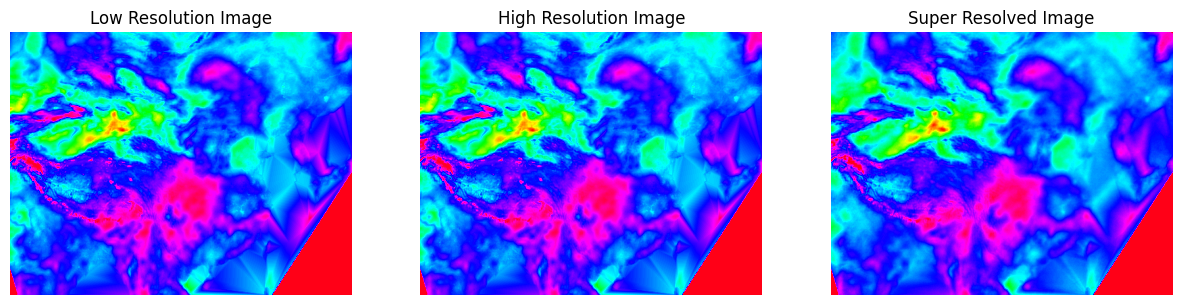

In [9]:
model = RCAN(num_features=64, num_groups=10, num_blocks=20, reduction=16, scale=10, in_channels=9, out_channels=1).to(device)
model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/RCAN_pet.pth'))
model.eval()  # 设置为评估模式

eva_image_path = 'D:/7_climate_10_520_400/12_PET/2020/PET_2020_07_01.tif'
tem_image_path = 'F:/3_climate_100_52_40/1_tem/2020/tem_2020_07_01.tif'
tem_min_image_path = 'F:/3_climate_100_52_40/3_tem_min/2020/tem_min_2020_07_01.tif'
tem_max_image_path = 'F:/3_climate_100_52_40/2_tem_max/2020/tem_max_2020_07_01.tif'
pr_image_path = 'F:/3_climate_100_52_40/7_tol_per/2020/per_2020_07_01.tif'
wind_image_path = 'F:/3_climate_100_52_40/4_wind_u/2020/wind_2020_07_01.tif'
ps_image_path = 'F:/3_climate_100_52_40/6_ps/2020/ps_2020_07_01.tif'
solar_image_path = 'F:/3_climate_100_52_40/8_solar_rad/2020/solar_rad_2020_07_01.tif'
ther_image_path = 'F:/3_climate_100_52_40/9_ther_rad/2020/ther_rad_2020_07_01.tif'
rh_image_path = 'F:/3_climate_100_52_40/11_rh/2020/rh_2020_07_01.tif'

eva_image = load_tiff_with_rasterio(eva_image_path)
tem_image = load_tiff_with_rasterio(tem_image_path)
tem_min_image = load_tiff_with_rasterio(tem_min_image_path)
tem_max_image = load_tiff_with_rasterio(tem_max_image_path)
pr_image = load_tiff_with_rasterio(pr_image_path)
pr_image = pr_image*1000
wind_image = load_tiff_with_rasterio(wind_image_path)
ps_image = load_tiff_with_rasterio(ps_image_path)
ps_image = ps_image/1000
solar_image = load_tiff_with_rasterio(solar_image_path)
solar_image = solar_image/86400
ther_image = load_tiff_with_rasterio(ther_image_path)
ther_image = ther_image/86400
rh_image = load_tiff_with_rasterio(rh_image_path)

transform = transforms.ToTensor()
tem_tensor = transform(tem_image).unsqueeze(0)
tem_min_tensor = transform(tem_min_image).unsqueeze(0)
tem_max_tensor = transform(tem_max_image).unsqueeze(0)
pr_tensor = transform(pr_image).unsqueeze(0)
wind_tensor = transform(wind_image).unsqueeze(0)
ps_tensor = transform(ps_image).unsqueeze(0)
solar_tensor = transform(solar_image).unsqueeze(0)
ther_tensor = transform(ther_image).unsqueeze(0)
rh_tensor = transform(rh_image).unsqueeze(0)
print(ther_tensor.shape)
lr_tensor= torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
print(lr_tensor.shape)
lr_tensor = lr_tensor.float().to(device)

vmin = eva_image[mask].min()
vmax = eva_image[mask].max()

model.to(device)
with torch.no_grad():
    sr_tensor = model(lr_tensor)
sr_image = sr_tensor.squeeze().cpu().numpy()

def plot_images(lr_image, hr_image, sr_image):


    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Low Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('High Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Super Resolved Image')
    plt.axis('off')

    plt.show()
plot_images(eva_image, eva_image, sr_image)

In [11]:
with rasterio.open(eva_image_path) as src:
    # 获取原始图像的地理信息（仿射变换矩阵和投影坐标系）
    transform = src.transform
    crs = src.crs
    profile = src.profile
profile.update(
    dtype=rasterio.float32,   # 数据类型为 float32
    count=1,                  # 1 个波段
    height=sr_image.shape[0], # 高度
    width=sr_image.shape[1],  # 宽度
    transform=transform        # 保持原始的地理变换信息
)

year = list(range(2000, 2024))
model.to(device)
transform = transforms.ToTensor()
for a_index, a in enumerate(year):
    start_date = f'{a}-01-01'
    end_date = f'{a}-12-31'
    date_range = pd.date_range(start=start_date, end=end_date)
    print(a)
    for b_index, b in enumerate(date_range):
        day_index = b_index
        date_day = date_range[day_index]
        date_day_year = date_day.year
        date_day_month = date_day.month
        date_day_day = date_day.day
        
        tem_path = f'F:/3_climate_100_52_40/1_tem/{a}/tem_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}/tem_min_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}/tem_max_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}/per_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}/wind_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ps_path = f'F:/3_climate_100_52_40/6_ps/{a}/ps_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}/solar_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}/ther_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        rh_path = f'F:/3_climate_100_52_40/11_rh/{a}/rh_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'

        output_path = f'J:/3_climate_output/1_climate_520_400/7_RCAN/12_pet/{a}/pet_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
     
        tem_image = load_tiff_with_rasterio(tem_path)
        tem_tensor = transform(tem_image).unsqueeze(0) 
        tem_tensor = tem_tensor.float().to(device)
        
        tem_min_image = load_tiff_with_rasterio(tem_min_path)
        tem_min_tensor = transform(tem_min_image).unsqueeze(0) 
        tem_min_tensor = tem_min_tensor.float().to(device)

        tem_max_image = load_tiff_with_rasterio(tem_max_path)
        tem_max_tensor = transform(tem_max_image).unsqueeze(0) 
        tem_max_tensor = tem_max_tensor.float().to(device)

        pr_image = load_tiff_with_rasterio(pr_path)
        pr_image = pr_image*1000
        pr_tensor = transform(pr_image).unsqueeze(0) 
        pr_tensor = pr_tensor.float().to(device)

        ps_image = load_tiff_with_rasterio(ps_path)
        ps_image = ps_image/1000
        ps_tensor = transform(ps_image).unsqueeze(0) 
        ps_tensor = ps_tensor.float().to(device)

        wind_image = load_tiff_with_rasterio(wind_path)
        wind_tensor = transform(wind_image).unsqueeze(0) 
        wind_tensor = wind_tensor.float().to(device)

        solar_image = load_tiff_with_rasterio(solar_path)
        solar_image = solar_image/86400
        solar_tensor = transform(solar_image).unsqueeze(0) 
        solar_tensor = solar_tensor.float().to(device)

        ther_image = load_tiff_with_rasterio(ther_path)
        ther_image = ther_image/86400
        ther_tensor = transform(ther_image).unsqueeze(0) 
        ther_tensor = ther_tensor.float().to(device)

        rh_image = load_tiff_with_rasterio(rh_path)
        rh_tensor = transform(rh_image).unsqueeze(0) 
        rh_tensor = rh_tensor.float().to(device)

        lr_tensor = torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
        
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_image = sr_tensor.squeeze().cpu().numpy()
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(sr_image.astype(rasterio.float32), 1)  # 将 sr_image 写入为第一个波段

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
